In [22]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import PIL
from torchvision.transforms.functional import to_pil_image


# CIFAR10 데이터셋 다운로드
## CIFAR10에 포함된 이미지의 크기는 3x32x32이고, 총 10개의 class가 있습니다.

[CIFAR10](https://tutorials.pytorch.kr/_images/cifar10.png)

In [5]:
data_transform = transforms.Compose([
            transforms.Resize((227, 227)),
            transforms.ToTensor(),
])

training_data = datasets.CIFAR10(
    root="data", # Download True일 시, 데이터를 다운받을 경로 // Download False일 시, 데이터가 존재하는 경로
    train=True,  # 훈련용 데이터
    download=True,
    transform=data_transform,
)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=data_transform,
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [11]:
batch_size = 64

# 데이터로더를 생성합니다.
train_dataloader = DataLoader(dataset=training_data,
    batch_size=batch_size,
    shuffle=True)
test_dataloader = DataLoader(dataset=test_data, 
    batch_size=batch_size,
    shuffle=False)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 227, 227])
Shape of y: torch.Size([64]) torch.int64


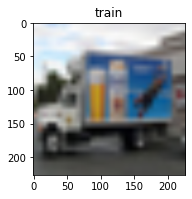

In [12]:
for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(to_pil_image(inputs[0]), cmap='gray')
    plt.title('train')
    break

In [34]:
# 학습에 사용할 CPU나 GPU 장치를 얻습니다.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class AlexNet(nn.Module):
    """
    Neural network model consisting of layers propsed by AlexNet paper.
    """
    def __init__(self, num_classes=10):
        """
        Define and allocate layers for this neural net.
        Args:
            num_classes (int): number of classes to predict with this model
        """
        super().__init__()
        # input size should be : (b x 3 x 227 x 227)
        # The image in the original paper states that width and height are 224 pixels, but
        # the dimensions after first convolution layer do not lead to 55 x 55.
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),  # (b x 96 x 55 x 55)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # section 3.3
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 27 x 27)
            nn.Conv2d(96, 256, 5, padding=2),  # (b x 256 x 27 x 27)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 13 x 13)
            nn.Conv2d(256, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, padding=1),  # (b x 384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1),  # (b x 256 x 13 x 13)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 6 x 6)
        )
        # classifier is just a name for linear layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        self.init_bias()  # initialize bias

    def init_bias(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.net[4].bias, 1)
        nn.init.constant_(self.net[10].bias, 1)
        nn.init.constant_(self.net[12].bias, 1)

    def forward(self, x):
        """
        Pass the input through the net.
        Args:
            x (Tensor): input tensor
        Returns:
            output (Tensor): output tensor
        """
        x = self.net(x)
        x = x.view(-1, 256 * 6 * 6)  # reduce the dimensions for linear layer input
        return self.classifier(x)

model = AlexNet().to(device)
print(model)

Using cuda device
AlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [37]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [38]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.287948  [    0/50000]
loss: 2.312526  [ 6400/50000]
loss: 2.320519  [12800/50000]
loss: 2.311314  [19200/50000]
loss: 2.322618  [25600/50000]
loss: 2.351674  [32000/50000]
loss: 2.344188  [38400/50000]
loss: 2.296188  [44800/50000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.307288 

Epoch 2
-------------------------------
loss: 2.308074  [    0/50000]
loss: 2.312770  [ 6400/50000]
loss: 2.302482  [12800/50000]
loss: 2.303481  [19200/50000]
loss: 2.298015  [25600/50000]
loss: 2.303394  [32000/50000]
loss: 2.309743  [38400/50000]
loss: 2.289558  [44800/50000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.307288 

Epoch 3
-------------------------------
loss: 2.319980  [    0/50000]
loss: 2.313066  [ 6400/50000]
loss: 2.321692  [12800/50000]
loss: 2.292490  [19200/50000]
loss: 2.309721  [25600/50000]
loss: 2.300601  [32000/50000]
loss: 2.309637  [38400/50000]
loss: 2.269425  [44800/50000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.307288 

Epoc

Epoch 1
-------------------------------
loss: 2.303670  [    0/60000]
loss: 2.301056  [ 6400/60000]
loss: 2.301539  [12800/60000]
loss: 2.290112  [19200/60000]
loss: 2.287209  [25600/60000]
loss: 2.286199  [32000/60000]
loss: 2.266811  [38400/60000]
loss: 2.288933  [44800/60000]
loss: 2.266318  [51200/60000]
loss: 2.252344  [57600/60000]
Test Error: 
 Accuracy: 46.7%, Avg loss: 2.256902 

Epoch 2
-------------------------------
loss: 2.255552  [    0/60000]
loss: 2.252667  [ 6400/60000]
loss: 2.261606  [12800/60000]
loss: 2.225046  [19200/60000]
loss: 2.235263  [25600/60000]
loss: 2.234912  [32000/60000]
loss: 2.206037  [38400/60000]
loss: 2.241807  [44800/60000]
loss: 2.203204  [51200/60000]
loss: 2.183715  [57600/60000]
Test Error: 
 Accuracy: 61.2%, Avg loss: 2.190518 

Epoch 3
-------------------------------
loss: 2.188668  [    0/60000]
loss: 2.181847  [ 6400/60000]
loss: 2.201895  [12800/60000]
loss: 2.131361  [19200/60000]
loss: 2.156991  [25600/60000]
loss: 2.154327  [32000/600